# How to Use This Library

## Importing Required Libraries

In [1]:
import logging
import sys
import os

sys.path.append('..')

from indic_aug.log import logger, change_logpath

## Getting the Data for This Example

This example uses the IIT Bombay English-Hindi Parallel Corpus available [here](https://www.cfilt.iitb.ac.in/~parallelcorp/iitb_en_hi_parallel/). Steps to obtain the data:

1. Download the parallel corpus (`parallel.tgz`) and save it in the `raw` directory.
2. Switch to the `raw` directory using `cd raw` and run `tar -xvf parallel.tgz` to unzip.
3. Run `./crop.sh` to extract a subset of the complete dataset.

When using your own data, make sure the bilingual corpus is split into two files, one for each language (similar to the example IIT Bombay dataset used here). The files must have the extension as the [ISO 639-1 code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes) for the language. For example, the file containing English sentences could be named as `data.en` and the file containing the corresponding Hindi sentences as `data.hi`. Make sure that the document on line number $n$ in the target file (`data.hi`) is a translation of the corresponding document on line number $n$ in the source file (`data.en`).

In [2]:
raw_hi_path = os.path.join('raw', 'data.hi')
raw_en_path = os.path.join('raw', 'data.en')

preproc_dir = 'preprocessed'
preproc_hi_path = os.path.join(preproc_dir, 'data.hi')
preproc_en_path = os.path.join(preproc_dir, 'data.en')

vocab_dir = 'vocab'

stanza_dir = 'stanza_resources'
polyglot_dir = 'polyglot_data'

Looking at the raw data.

In [3]:
import pandas as pd

pd.concat([pd.read_csv(raw_hi_path, sep='\t', nrows=10, header=None), pd.read_csv(raw_en_path, sep='\t', nrows=10, header=None)], axis=1)

,0,0
0,"वर्तमान में, 38 टीएसडीएफ में क्रमशः 17 एकीकृत ...","At present, 38 TSDFs include 17 Integrated TSD..."
1,ये राज्य / केन्द्र शासित प्रदेश क्रमशः कुल देश...,These States /UT contribute about 97.8% of tot...
2,"2013-14 के दौरान, देश भर में खतरनाक कचरे के लि...","During 2013-14, financial assistance has been ..."
3,ई-कचरा प्रबंधन:,E-Waste Management:
4,पर्यावरण और वन मंत्रालय ने मई 2011 में ई-कचरा ...,"The Ministry of Environment and Forest, has no..."
5,इन नियमों में विस्तारित निर्माता जिम्मेदारी (ई...,The concept of Extended Producers Responsibili...
6,"इन नियमों के अनुसार, उत्पादकों को संग्रह केंद्...",As per these Rules the producers are required ...
7,ई-कचरे की रीसाइक्लिंग को केवल राज्य प्रदूषण नि...,E-waste recycling can be undertaken only in fa...
8,उत्पन्न कचरे को एक पंजीकृत या अधिकृत रिसाइकलर ...,Wastes generated are required to be sold to a ...
9,नियम में व्यक्तिगत रूप से या संयुक्त रूप से सं...,The rule has provision for setting up of Colle...


## Jump to Section

[Preprocessing, Tokenization & Building the Vocabulary](#preproc)<br>
[DropoutAugmentor](#dropout)<br>
[NoisingAugmentor](#noising)<br>
[SynonymAugmentor](#synonym)<br>
[DepParseTree and DepParseAugmentor](#depparse)<br>
[Aligner](#aligner)<br>
[TDAugmentor](#tda)<br>
[ClosestEmbeddingAugmentor](#closest)

<a id="preproc"></a>

## Preprocessing, Tokenization & Building the Vocabulary

The `preprocess` module has methods for tokenization and building the vocabulary.

In [4]:
from indic_aug.preprocess import Preprocessor

In [5]:
%%bash

rm -rf preprocessed
mkdir preprocessed

In [6]:
preproc = Preprocessor(
    raw_hi_path,
    raw_en_path,
    stanza_dir=stanza_dir
)

# Processing before building the vocabulary.
preproc.pre_vocab(
    'temp.hi',      # Temporary file to store prevocab output for source.
    'temp.en',      # Temporary file to store prevocab output for target.
    512             # Number of parallel documents to bring into memory at a time.
)

# Building the vocabulary.
preproc.build_vocab(
    10000,
    10000,
    vocab_dir
)

# Processing after building the vocabulary (replacing OOV words with UNK_TOKEN).
preproc.post_vocab(
    preproc_hi_path,
    preproc_en_path
)

INFO:indic_aug:Tokenizing... [batch_size=512, batch_count=59]
100%|██████████| 59/59 [00:59<00:00,  1.01s/it]
INFO:indic_aug:Generating vocabulary...
INFO:indic_aug:Replacing OOV words in source corpus with <unk> token...
100%|██████████| 30000/30000 [00:58<00:00, 511.31it/s]
INFO:indic_aug:Replacing OOV words in target corpus with <unk> token...
100%|██████████| 30000/30000 [00:43<00:00, 696.54it/s] 


<a id="dropout"></a>

## `DropoutAugmentor`

This section shows how to use the `DropoutAugmentor` from the `basic` package.

In [7]:
from indic_aug.basic import DropoutAugmentor

In [8]:
# Redirecting logs from default stderr to file.
change_logpath(os.path.join('logs', 'dropout.log'))

# Initializing augmentor object.
dropoutAugmentor = DropoutAugmentor(
    preproc_hi_path,
    preproc_en_path,
    0.05,
)

# Generating augmented documents.
i = 0
for augmentedPair in dropoutAugmentor:
    if i == 10:
        break
    else:
        i += 1

<a id="noising"></a>

## `NoisingAugmentor`

This section shows how to use the `NoisingAugmentor` from the basic package.

In [9]:
from indic_aug.basic import NoisingAugmentor

You can use the following modes with `NoisingAugmentor`:
* 'blank'
* 'replace'
* 'absolute_discount'
* 'kneser_ney'

These modes are described in detail in the paper [Data Noising as Smoothing in Neural Network Language Models](https://arxiv.org/abs/1703.02573) by Z. Xie, S. I. Wang, et al.

This example uses the 'blank' mode.

In [10]:
# Redirecting logs from default stderr to file.
change_logpath(os.path.join('logs', 'noising.log'))

# Initializing augmentor object.
noisingAugmentor = NoisingAugmentor(
    preproc_hi_path,
    preproc_en_path,
    'blank',
    0.1
)

# Generating augmented documents.
i = 0
for augmentedPair in noisingAugmentor:
    if i == 10:
        break
    else:
        i += 1

<a id="synonym"></a>

## `SynonymAugmentor`

This section shows how to use the `SynonymAugmentor` from the `basic` package.

In [11]:
from indic_aug.basic import SynonymAugmentor

In [12]:
# Redirecting logs from default stderr to file.
change_logpath(os.path.join('logs', 'synonym.log'))

# Initializing augmentor object.
synonymAugmentor = SynonymAugmentor(
    preproc_hi_path,
    preproc_en_path,
    vocab_dir,
    0.3,
    stanza_dir=stanza_dir
)

# Generating augmented documents.
i = 0
for augmentedPair in synonymAugmentor:
    if i == 10:
        break
    else:
        i += 1

<a id="depparse"></a>

## `DepParseTree` and `DepParseAugmentor`

This section shows how to use `DepParseTree` and `DepParseAugmentor` from the `depparse` package.

In [13]:
import graphviz

from indic_aug.depparse import DepParseTree
from indic_aug.utils import load_stanza_pipeline

Creating the sentence in the desired form as expected by `DepParseTree`.

In [14]:
pipeline = load_stanza_pipeline('en', stanza_dir='stanza_resources')
sent = pipeline('Jack hit the ball with the bat').sentences[0]

Creating the dependency parse tree and saving it as a GraphViz DOT file.

In [15]:
deptree = DepParseTree(sent)
deptree.save_tree('deptree.gv')

Plotting the graph.

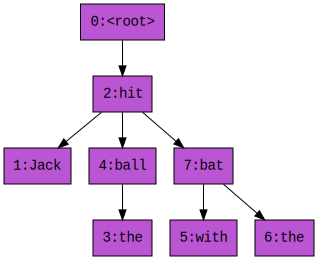

In [16]:
graphviz.Source.from_file('deptree.gv')

Note that the relatively less important<sup>*</sup> word 'the' is a leaf node. Words that contribute less to the meaning of the sentence tend to be located towards the leaves and vice versa.

<sup>*</sup>Less important in the sense that removing these words from the sentence keeps the semantics relatively intact, i.e., it is possible to understand broadly what the sentence 
<center>'Jack hit ball with bat'</center>
means, even after dropping 'the'.

In [17]:
from indic_aug.depparse import DepParseAugmentor

In [18]:
# Redirecting logs from default stderr to file.
change_logpath(os.path.join('logs', 'depparse.log'))

# Initializing augmentor object.
depparseAugmentor = DepParseAugmentor(
    os.path.join('preprocessed', 'data.hi'),
    os.path.join('preprocessed', 'data.en'),
    'blank',
    0.1,
    stanza_dir=stanza_dir
)

# Generating augmented documents.
i = 0
for augmentedPair in depparseAugmentor:
    if i == 10:
        break
    else:
        i += 1

<a id="aligner"></a>

## `Aligner`

This section shows how to train an alignment model using `Aligner` from the `align` module.

In [19]:
from indic_aug.align import Aligner

In [20]:
%%script echo "Comment the line with \"%%script echo\" to run training again (this might take some time)."
%%time

aligner = Aligner('ibm1', 10)
aligner.train(preproc_hi_path, preproc_en_path)
aligner.serialize('aligner.pkl')

Comment the line with "%%script echo" to run training again (this might take some time).


In [21]:
aligner = Aligner.load('aligner.pkl')

Using `Aligner` as a word to word translator.

In [22]:
for word in [
    'space',
    'economy',
    'science',
    'ordinary',
    'resolve',
    'standards',
    'high',
    'broadcast',
    'number',
    'conclave',
    'colleges',
    'technology',
    'quality',
    'officer',
    'city'
]:
    print(f'{word} - {aligner.tgt2src(word)}')

space - अंतरिक्ष
economy - अर्थव्यवस्था
science - विज्ञान
ordinary - साधारण
resolve - संकल्प
standards - मानकों
high - ऊंचे
broadcast - प्रसारण
number - संख्या
conclave - प्रबासी
colleges - महाविद्यालयों
technology - प्रौद्योगिकी
quality - गुणवत्ता
officer - अधिकारी
city - शहर


In [23]:
for word in [
    'अंतरिक्ष',
    'अर्थव्यवस्था',
    'विज्ञान',
    'साधारण',
    'संकल्प',
    'मानकों',
    'ऊंचे',
    'प्रसारण',
    'संख्या',
    'प्रबासी',
    'महाविद्यालयों',
    'प्रौद्योगिकी',
    'गुणवत्ता',
    'अधिकारी',
    'शहर'
]:
    print(f'{word} - {aligner.src2tgt(word)}')

अंतरिक्ष - space
अर्थव्यवस्था - economy
विज्ञान - science
साधारण - an
संकल्प - resolve
मानकों - standards
ऊंचे - high
प्रसारण - broadcast
संख्या - number
प्रबासी - conclave
महाविद्यालयों - colleges
प्रौद्योगिकी - technology
गुणवत्ता - quality
अधिकारी - officials
शहर - city


Note that `tgt2src` and `src2tgt` are not necessarily inverses of each other (though ideally they are). This fact can easily be explained by visualizing the translation table. 

Suppose: 
* The translation table $T$ containing the alignment scores is structured so that target words are along rows and source words along columns.
* $s$ is the source word with the highest alignment score for target word $t$ (as given by `tgt2src`), i.e., $T[t][s] = \max T[t][:]$.

Then running `src2tgt` on $s$ will return $t$ if
$$T[t][s] = \max T[:][s]$$

In [24]:
src1 = 'उन्होंने कहा कि यह एक सही संकेत है ।'
tgt1 = 'He said that this is a right sign .'

src2 = 'विभिन्न योजनाओं और प्रक्रियाओं का लाभ उठाने के बारे में जानकारी ।'
tgt2 = 'information about various schemes and procedure to avail benefits .'

src3 = 'हमारी साझेदारी विश्व में शांति और स्थिरता के लिए भी उपयोगी है ।'
tgt3 = 'Our partnership is also useful for peace and stability in the world .'

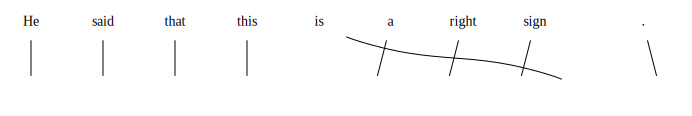

In [25]:
aligner.align(src1, tgt1)

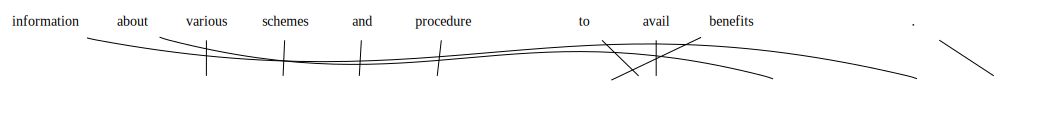

In [26]:
aligner.align(src2, tgt2)

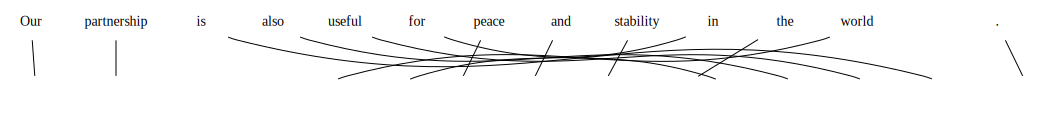

In [27]:
aligner.align(src3, tgt3)

As can be seen above, it becomes difficult to visualize the alignments when the sentences become long. You can instead use the `plot_alignment` method in the `Align` object.

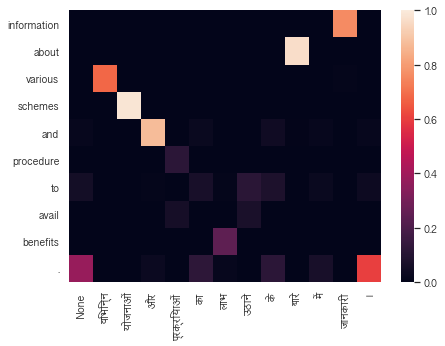

In [28]:
aligner.plot_alignment(src2, tgt2, 'Devanagari Sangam MN', figsize=(7, 5))

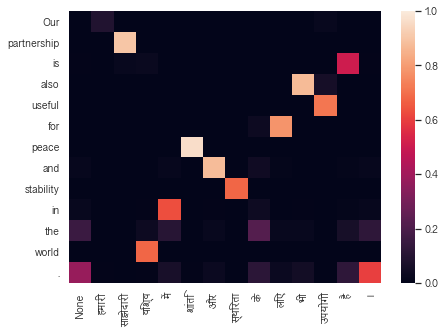

In [29]:
aligner.plot_alignment(src3, tgt3, 'Devanagari Sangam MN', figsize=(7, 5))

<a id="tda"></a>

## `TDAugmentor`

This section shows how to use the `TDAugmentor` from the `embedding` package.

In [30]:
from indic_aug.align import Aligner
from indic_aug.tda import TDAugmentor

Using the same `Aligner` object trained in the previous section.

IMPORTANT:

* Jupyter has an issue with nested async. If the following cell gives a `FileNotFoundError`, run the following lines from a `.py` file

    ```
    from indic_aug.lm import fetch

    fetch('hi')
    ```

    and then run the cell again.

* If you are trying to run augmentation where the source language is English and you get an error, you will need to downgrade your version of `spacy` to `2.x` (refer [this](https://github.com/goru001/inltk/issues/71) issue).

In [31]:
# Redirecting logs from default stderr to file.
change_logpath(os.path.join('logs', 'tda.log'))

# Initializing augmentor object.
tdAugmentor = TDAugmentor(
    preproc_hi_path,
    preproc_en_path,
    Aligner.load('aligner.pkl'),
    3000,
    vocab_dir
)

# Generating augmented documents.
for i in range(10):
    next(tdAugmentor)

OSError: Not found: "/usr/local/Caskroom/miniconda/base/envs/nmt/lib/python3.7/site-packages/inltk/models/hi/tokenizer.model": No such file or directory Error #2

<a id="closest"></a>

## `ClosestEmbeddingAugmentor`

This section shows how to use the `ClosestEmbeddingAugmentor` from the `embedding` package.

In [3]:
from indic_aug.align import Aligner
from indic_aug.embedding import ClosestEmbeddingAugmentor

Using the same `Aligner` object trained in the previous section.

In [4]:
# Redirecting logs from default stderr to file.
change_logpath(os.path.join('logs', 'closest.log'))

# Initializing the augmentor object.
closestAugmentor = ClosestEmbeddingAugmentor(
    preproc_hi_path,
    preproc_en_path,
    Aligner.load('aligner.pkl'),
    0.3,
    vocab_dir,
    polyglot_dir=polyglot_dir
)

# Generating augmented documents.
for i in range(10):
    next(closestAugmentor)